In [28]:
# 引入相关库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM      
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint

plt.style.use('fivethirtyeight')

In [29]:
# 导入数据
# dataset = './data/BTC.csv'
# dataset.head()
# training_set = dataset[:'2017'].iloc[:,3:4].values
# test_set = dataset['2018':].iloc[:,3:4].values
# training_set

           Date  Close   Open   High    Low   Volume  Fluctuation
0     1988/6/26  14.60  15.10  15.47  14.60     0.68      -0.0671
1      1988/7/3  15.05  14.50  15.45  14.30     1.50       0.0308
2     1988/7/10  14.18  14.70  15.12  13.79     1.81      -0.0578
3     1988/7/17  15.71  14.25  15.71  14.20     1.69       0.1079
4     1988/7/24  15.70  15.70  15.90  15.22     2.16      -0.0006
...         ...    ...    ...    ...    ...      ...          ...
1821  2023/6/18  73.85  76.40  77.24  72.11  1150.00      -0.0360
1822  2023/6/25  74.90  74.50  75.40  71.57   490.35       0.0142
1823   2023/7/2  78.47  75.11  78.54  74.56  1110.00       0.0477
1824   2023/7/9  79.87  78.60  81.75  77.36  1710.00       0.0178
1825  2023/7/16  79.52  79.34  80.92  78.20   311.44      -0.0044

[1826 rows x 7 columns]
                Close      Open      High       Low    Volume  Fluctuation
Close        1.000000  0.950840  0.968802  0.970301  0.542615     0.029644
Open         0.950840  1.000000  

C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_21244\62418260.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr('kendall')


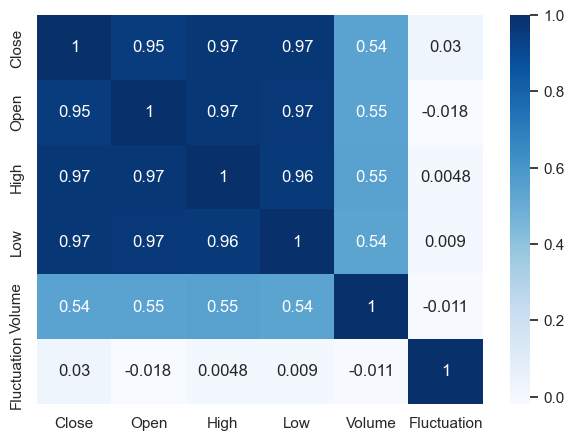

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取DataFrame数据集
df = pd.read_csv("./data/weeks/all_week_data.csv")
print(df)
# print(df.to_string())
corr_matrix = df.corr('kendall')
print(corr_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
 
 
sns.set(font_scale=1.0)
sns.heatmap(corr_matrix, cmap="Blues", annot=True, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.show()


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取DataFrame数据集
df = pd.read_csv("./data/weeks/all_week_data.csv")

# 计算分割点
split_point = int(0.9 * len(df))

# 将DataFrame数据集分成训练集和测试集
train_df = df.iloc[:split_point, :]
test_df = df.iloc[split_point:, :]

# 将train_df和test_df的Date列转换为datetime格式，并作为索引
train_df["Date"] = pd.to_datetime(train_df["Date"])
train_df.set_index("Date", inplace=True)
test_df["Date"] = pd.to_datetime(test_df["Date"])
test_df.set_index("Date", inplace=True)

# 输出训练集和测试集的大小
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))
test_df

Training set size: 1643
Testing set size: 183


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_21244\1868172156.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Date"] = pd.to_datetime(train_df["Date"])
C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_21244\1868172156.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Date"] = pd.to_datetime(test_df["Date"])


,Close,Open,High,Low,Volume,Fluctuation
Date,,,,,,
2019-12-22,68.16,66.15,68.33,65.81,419.89,0.0305
2019-12-29,68.60,68.20,69.50,65.63,885.81,0.0065
2020-01-05,64.98,69.35,71.75,64.56,1820.00,-0.0528
2020-01-12,64.85,65.13,65.60,63.55,1220.00,-0.0020
2020-01-19,60.69,65.98,66.00,60.25,1300.00,-0.0641
...,...,...,...,...,...,...
2023-06-18,73.85,76.40,77.24,72.11,1150.00,-0.0360
2023-06-25,74.90,74.50,75.40,71.57,490.35,0.0142
2023-07-02,78.47,75.11,78.54,74.56,1110.00,0.0477


<Figure size 1000x2000 with 0 Axes>

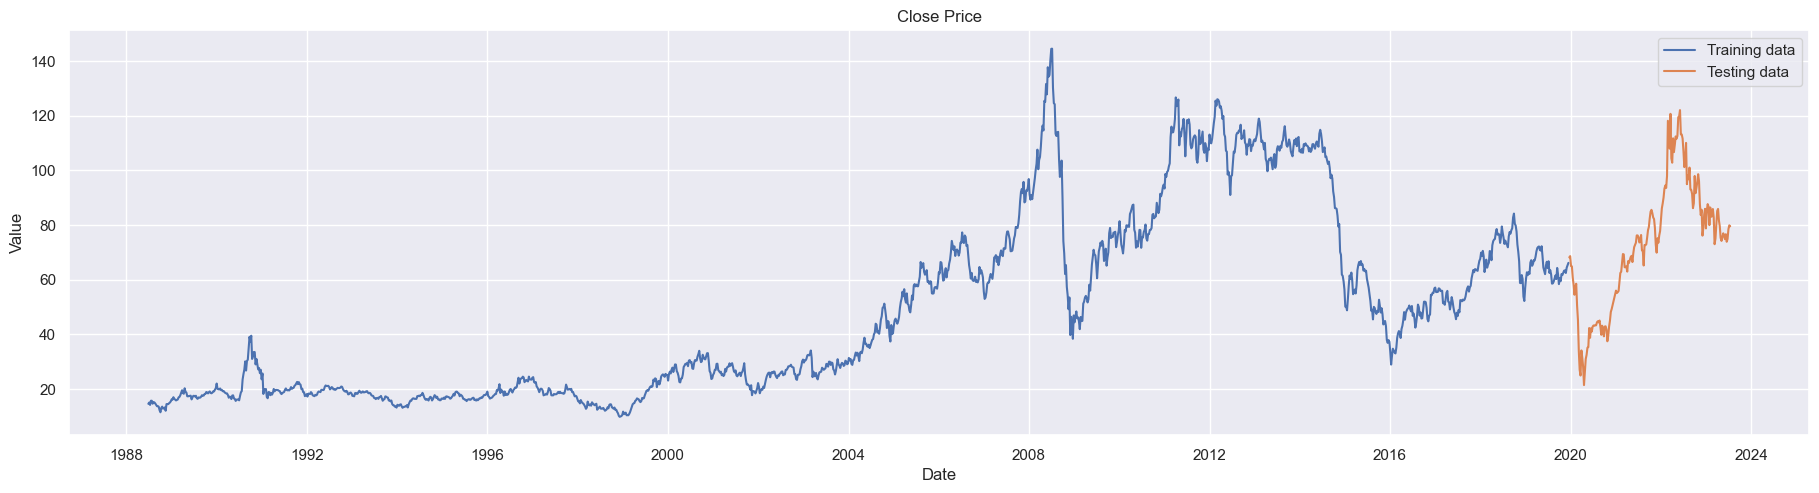

In [32]:
# 绘制训练集中每一列的图表
fig = plt.figure(figsize=(10, 20))

# 绘制训练集中A列的图表
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(train_df["Close"], label="Training data")

# 绘制测试集中A列的图表
ax.plot(test_df["Close"], label="Testing data")

# 设置图表标题和轴标签
ax.set_title("Close Price")
ax.set_xlabel("Date")
ax.set_ylabel("Value")

# 添加图例
ax.legend()

# 显示图表
plt.show()

In [33]:
seq_len = 6
d = 0.2
shape = [6, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 100

In [34]:
# 如果不添加这句，是无法直接在jupyter里看到图的
import seaborn as sns
sns.set(style="darkgrid")
df

,Date,Close,Open,High,Low,Volume,Fluctuation
0,1988/6/26,14.60,15.10,15.47,14.60,0.68,-0.0671
1,1988/7/3,15.05,14.50,15.45,14.30,1.50,0.0308
2,1988/7/10,14.18,14.70,15.12,13.79,1.81,-0.0578
3,1988/7/17,15.71,14.25,15.71,14.20,1.69,0.1079
4,1988/7/24,15.70,15.70,15.90,15.22,2.16,-0.0006
...,...,...,...,...,...,...,...
1821,2023/6/18,73.85,76.40,77.24,72.11,1150.00,-0.0360
1822,2023/6/25,74.90,74.50,75.40,71.57,490.35,0.0142
1823,2023/7/2,78.47,75.11,78.54,74.56,1110.00,0.0477
1824,2023/7/9,79.87,78.60,81.75,77.36,1710.00,0.0178


In [35]:
# 归一化
def get_stock_data(normalize=True):
    df = pd.read_csv('./data/weeks/all_week_data.csv', index_col='Date', parse_dates=['Date'])
    min_max_scaler = preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df['High'].values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['Volume'] = min_max_scaler.fit_transform(df['Volume'].values.reshape(-1,1))
    df['Fluctuation'] = min_max_scaler.fit_transform(df['Fluctuation'].values.reshape(-1,1))
    # df['BTC Volume'] = min_max_scaler.fit_transform(df['BTC Volume'].values.reshape(-1,1))
    # df['ETH Price'] = min_max_scaler.fit_transform(df['ETH Price'].values.reshape(-1,1))
    # df['XRP Price'] = min_max_scaler.fit_transform(df['XRP Price'].values.reshape(-1,1))
    # df['LTC Price'] = min_max_scaler.fit_transform(df['LTC Price'].values.reshape(-1,1))
    # df['Oil price'] = min_max_scaler.fit_transform(df['Oil price'].values.reshape(-1,1))
    # df['Gold Price'] = min_max_scaler.fit_transform(df['Gold Price'].values.reshape(-1,1))
    # df['DJI Price'] = min_max_scaler.fit_transform(df['DJI Price'].values.reshape(-1,1))
    return df
 
df = get_stock_data(normalize=True)
df

,Close,Open,High,Low,Volume,Fluctuation
Date,,,,,,
1988-06-26,0.035494,0.038304,0.037822,0.038849,0.000000,0.339654
1988-07-03,0.038836,0.033842,0.037677,0.036541,0.000311,0.488167
1988-07-10,0.032375,0.035329,0.035272,0.032618,0.000428,0.353762
1988-07-17,0.043737,0.031982,0.039571,0.035772,0.000383,0.605127
1988-07-24,0.043662,0.042767,0.040956,0.043619,0.000561,0.440534
...,...,...,...,...,...,...
2023-06-18,0.475459,0.494236,0.487976,0.481268,0.435461,0.386833
2023-06-25,0.483255,0.480104,0.474566,0.477114,0.185529,0.462985
2023-07-02,0.509765,0.484641,0.497449,0.500115,0.420305,0.513805


               Close      Open      High       Low    Volume  Fluctuation
Date                                                                     
1988-06-26  0.035494  0.038304  0.037822  0.038849  0.000000     0.339654
1988-07-03  0.038836  0.033842  0.037677  0.036541  0.000311     0.488167
1988-07-10  0.032375  0.035329  0.035272  0.032618  0.000428     0.353762
1988-07-17  0.043737  0.031982  0.039571  0.035772  0.000383     0.605127
1988-07-24  0.043662  0.042767  0.040956  0.043619  0.000561     0.440534


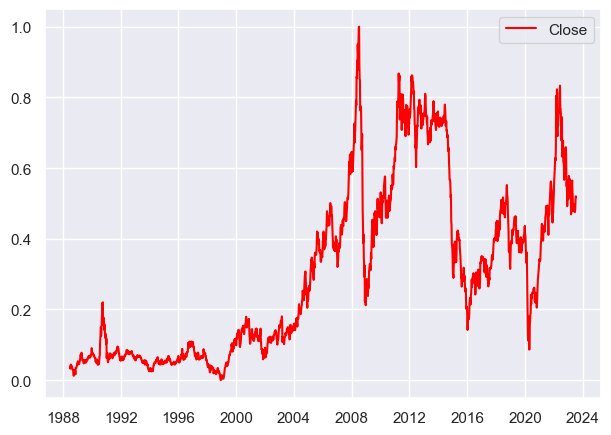

In [36]:
# 绘制正则化后的标签数据
df = get_stock_data(normalize=True)
print(df.head())
plt.plot(df['Close'], color='red', label='Close')
plt.legend(loc='best')
plt.show()

In [37]:
# 把最后一天的 Close作为y值
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split   1580条数据*0.9
    train = result[:int(row), :] # 90% date
#     X_train = train[:, :-1]
#     y_train = train[:,-1][:,4] #close price
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-5] # day m + 1 adjusted close price
    
#     X_test = result[int(row):, :-1]
#     y_test = result[int(row):,4]
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-5] 
 
    print(result)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  
 
    return [X_train, y_train, X_test, y_test]
 
X_train, y_train, X_test, y_test = load_data(df, seq_len)
# X_test

[[[3.54941709e-02 3.83042023e-02 3.78224749e-02 3.88491422e-02
   0.00000000e+00 3.39654126e-01]
  [3.88356724e-02 3.38415768e-02 3.76767235e-02 3.65412724e-02
   3.10686086e-04 4.88167476e-01]
  [3.23754363e-02 3.53291186e-02 3.52718263e-02 3.26178937e-02
   4.28140582e-04 3.53762136e-01]
  ...
  [4.36622856e-02 4.27668278e-02 4.09561288e-02 4.36187399e-02
   5.60750496e-04 4.40533981e-01]
  [3.57169377e-02 4.23205653e-02 3.90613613e-02 3.79259943e-02
   4.47084855e-04 3.37985437e-01]
  [3.99495062e-02 3.90479732e-02 3.76767235e-02 4.19263020e-02
   5.98639043e-04 5.00606796e-01]]

 [[3.88356724e-02 3.38415768e-02 3.76767235e-02 3.65412724e-02
   3.10686086e-04 4.88167476e-01]
  [3.23754363e-02 3.53291186e-02 3.52718263e-02 3.26178937e-02
   4.28140582e-04 3.53762136e-01]
  [4.37365412e-02 3.19821495e-02 3.95714910e-02 3.57719825e-02
   3.82674325e-04 6.05127427e-01]
  ...
  [3.57169377e-02 4.23205653e-02 3.90613613e-02 3.79259943e-02
   4.47084855e-04 3.37985437e-01]
  [3.99495062e-0

<Figure size 1000x2000 with 0 Axes>

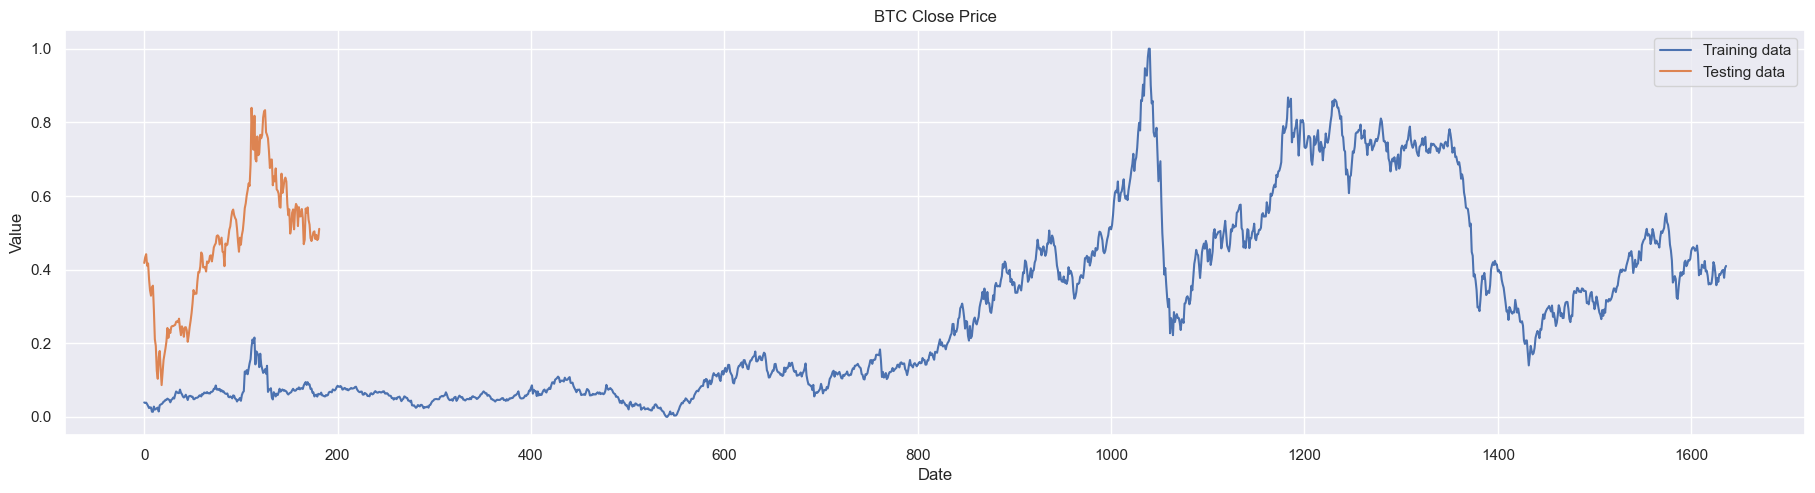

In [38]:
# 绘制训练集中每一列的图表
fig = plt.figure(figsize=(10, 20))

# 绘制训练集中A列的图表
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(y_train, label="Training data")

# 绘制测试集中A列的图表
ax.plot(y_test, label="Testing data")

# 设置图表标题和轴标签
ax.set_title("BTC Close Price")
ax.set_xlabel("Date")
ax.set_ylabel("Value")

# 添加图例
ax.legend()

# 显示图表
plt.show()

In [39]:
# seq_len = 6
# d = 0.2
# shape = [6, seq_len, 1] # feature, window, output
# neurons = [128, 128, 32, 1]
# epochs = 100

def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[2]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
 
model = build_model2(shape, neurons, d)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 6, 128)            69120     
                                                                 
 dropout_4 (Dropout)         (None, 6, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 204,865
Trainable params: 204,865
Non-tr

In [40]:
history=model.fit(
    X_train,
    y_train,
    batch_size=72,
    epochs=300,
    validation_split=0.1,
    verbose=1)

Epoch 1/300
21/21 [==============================] - 3s 42ms/step - loss: 0.0801 - accuracy: 0.0014 - val_loss: 0.0204 - val_accuracy: 0.0000e+00
Epoch 2/300
21/21 [==============================] - 0s 14ms/step - loss: 0.0077 - accuracy: 0.0014 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 3/300
21/21 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 0.0014 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 4/300
21/21 [==============================] - 0s 13ms/step - loss: 0.0018 - accuracy: 0.0014 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 5/300
21/21 [==============================] - 0s 13ms/step - loss: 0.0017 - accuracy: 0.0014 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/300
21/21 [==============================] - 0s 13ms/step - loss: 0.0016 - accuracy: 0.0014 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 7/300
21/21 [==============================] - 0s 13ms/step - loss: 0.0016 - accuracy: 0.0014 - val_loss: 0.0011 - val

KeyboardInterrupt: 

: 

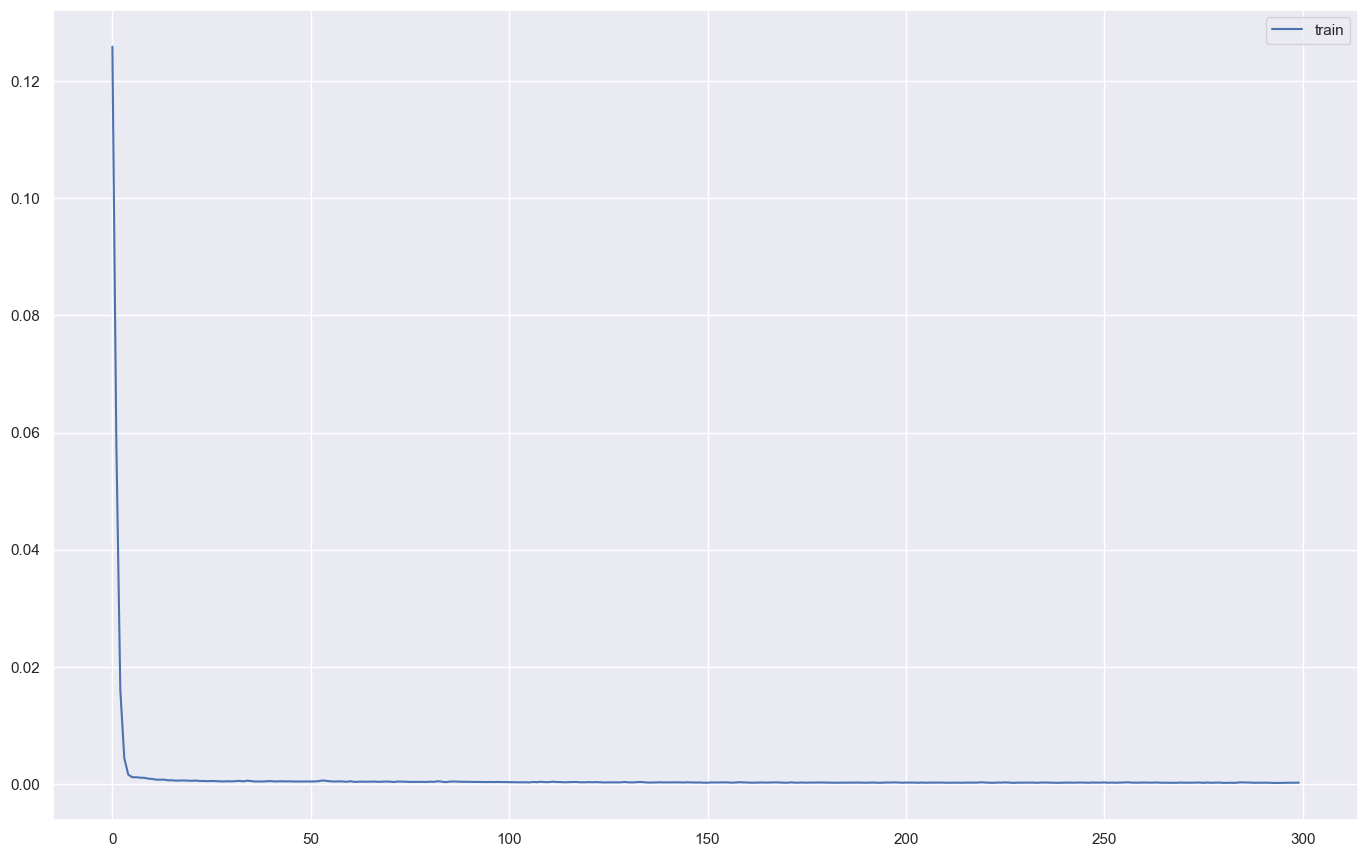

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='tezst')
plt.legend()
plt.show()
# pd.DataFrame(history.history['loss']).to_csv('./lose.csv')


In [ ]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
 
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
 
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00002 MSE (0.00 RMSE)
Test Score: 0.00010 MSE (0.01 RMSE)


(2.1364605345297605e-05, 9.948453225661069e-05)

In [ ]:
# 可视化预测结果
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]
 
    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u
 
        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

p = percentage_difference(model, X_test, y_test)

6/6 [==============================] - 1s 2ms/step


In [ ]:
# 反归一化
def denormalize(normalized_value):
    df = pd.read_csv('./data/BTC.csv', index_col='Date', parse_dates=['Date'])
    
    df = df['Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [ ]:
plt.style.use('fivethirtyeight')
def plot_result(normalized_value_p, normalized_value_y_test):
#     p反归一化
    newp = denormalize(normalized_value_p)
#     test 返归一化
    newy_test = denormalize(normalized_value_y_test)
                            
    plt.figure(figsize=(25, 6))
    plt.plot(newp, color='red', label='Prediction')
    pd.DataFrame(newp).to_csv('./result1.csv')
    
    plt.plot(newy_test,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('BTC Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('BTC Price')
    plt.show()

# pd.DataFrame(history.history['loss']).to_csv('./lose.csv')

plot_result(p, y_test)
newp = denormalize(p)

FileNotFoundError: [Errno 2] No such file or directory: './data/BTC.csv'

In [ ]:
# 以 预测准确率=（预测正确样本数）/（总测试样本数）* 100% 对预测准确率进行计算，设定 ErrorTolerance = 5%
def accuracy(predict, true):
    sizeofall = len(true)
    sizeofright = 0
    for i in range(0, sizeofall):
        est = abs(predict[i] - true[i]) / true[i]
        if est < 0.05:
            sizeofright = sizeofright + 1

    return sizeofright/sizeofall

In [ ]:
# y_test
# 将预测准确率打印出来
# predict = np.array(predicted_stock_price)
# true = np.array(test_set)
Ac = accuracy(p, y_test)
print("Accuracy=", Ac*100, '%')

Accuracy= 52.86624203821656 %


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# 打印MAPE
MAPE = metrics.mean_absolute_percentage_error(p, y_test)
print("MAPE=", MAPE*100, '%')

MAPE= 5.70259100967272 %


NameError: name 'tf' is not defined